# load data

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
import pandas as pd

sensor = pd.read_csv('https://raw.githubusercontent.com/shadgriffin/machine_failure/master/equipment_failure_data_1.csv')
sensor.head()


#,"DoleLR"	,"PID",	"outpressure",	"inpressure",	"temp"]]

ys_failure=sensor['EQUIPMENT_FAILURE']==1
ys_no_failure=sensor['EQUIPMENT_FAILURE']==0
sensor_failure=sensor[ys_failure].truncate(after=3000)
sensor_no_failure=sensor[ys_no_failure].truncate(after=3)

#sensor_no_failure.head(30)


Xs=sensor[["S15",	"S17"	,"S13","S15","S16"]]#.truncate(after=10000)	
ys=sensor['EQUIPMENT_FAILURE']#.truncate(after=10000)
sensor.head()

sensor_sorted=sensor.sort_values(by=['DATE'], ascending=True)
Xdate=sensor_sorted["DATE"]#.truncate(after=10000)	
yvalue=sensor_sorted["S5"]#.truncate(after=10000)	

sensor_sorted.head(10)
sensor_sorted_ohne_date=sensor_sorted[['ID', 'REGION_CLUSTER', 'MAINTENANCE_VENDOR', 'MANUFACTURER',
       'WELL_GROUP', 'S15', 'S17', 'S13', 'S5', 'S16', 'S19', 'S18',
       'EQUIPMENT_FAILURE', 'S8', 'AGE_OF_EQUIPMENT']]
sensor_sorted_ohne_date.head()

,ID,REGION_CLUSTER,MAINTENANCE_VENDOR,MANUFACTURER,WELL_GROUP,S15,S17,S13,S5,S16,S19,S18,EQUIPMENT_FAILURE,S8,AGE_OF_EQUIPMENT
83364,100372,B,M,S,4,10.3896,174.73,32.3000,2875.00,8.7674,0.6,3.8,0,0.00,8830
144768,100597,A,O,U,4,22.8000,0.00,35.0900,2667.00,6.5025,8.3,102.2,0,0.00,5510
30732,100139,G,N,T,3,23.5200,0.00,40.7304,3624.92,5.8855,20.3,30.5,0,0.00,990
37311,100164,H,P,S,1,20.1600,0.00,33.3400,3968.00,6.9040,25.3,177.8,0,108.43,2730
51931,100237,E,K,W,3,7.0992,142.74,38.7400,2944.00,7.3688,3.2,6.0,0,0.00,670


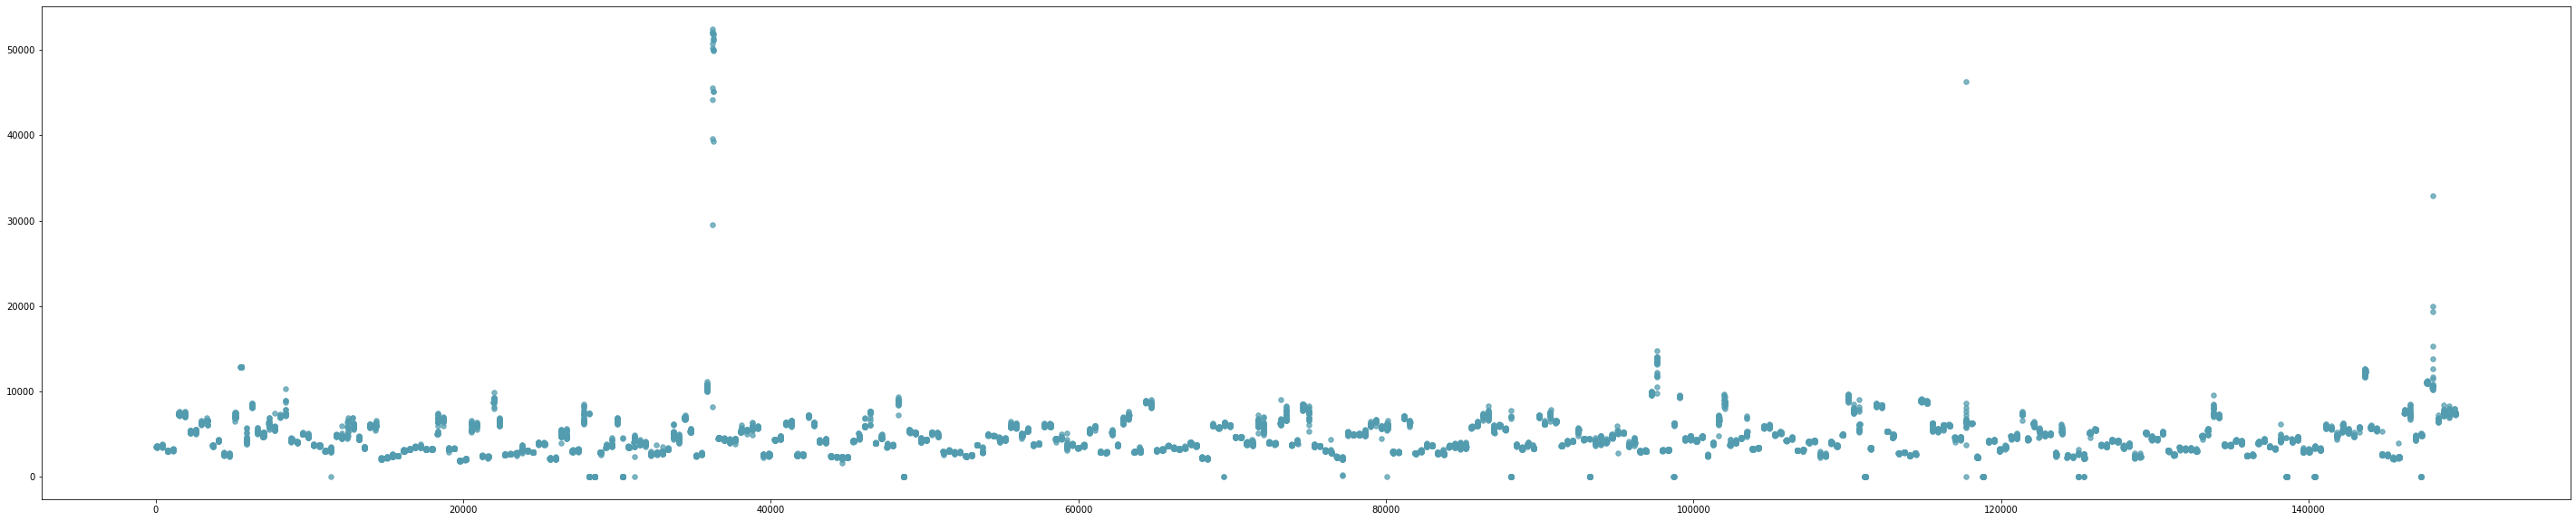

In [37]:
scatterplot(sensor_sorted.index.values[:9000],
                yvalue[:9000], 
                'Date', 
                'Gasoline Price (Dollars Per Gallon)', 
                'US Gulf Coast Gasoline Price Time Series: 2014-Present')

# use pickel save/load model

In [2]:
import pickle

from sklearn import svm
from sklearn.model_selection import train_test_split
#Create a svm Classifier
#kernel ooption _ linear, rbf, Polynomial 
clf = svm.SVC(C=1.0, kernel='linear') # Linear Kernel



X_train, X_test, y_train, y_test = train_test_split(Xs, ys, random_state=0)

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_hat = clf.predict(X_test)
score=clf.score(X_test, y_hat)
score




1.0

In [12]:
#save model
pickle.dump(clf, open('model_clf.pkl','wb'))

model = pickle.load(open('model_clf.pkl','rb'))


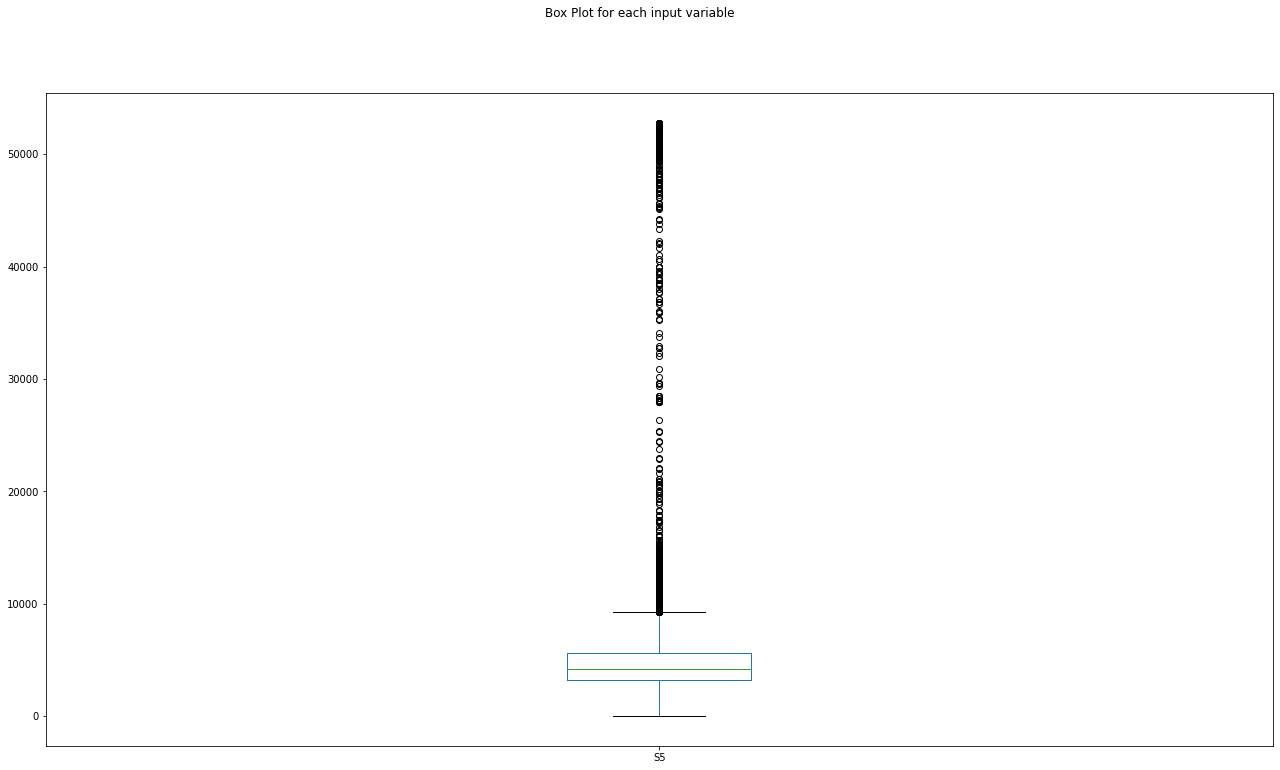

In [109]:
#box plot for each input feature
sensor['S5'].plot(kind='box', subplots=True, sharex=False, sharey=False, figsize=(22,12), 
                                        title='Box Plot for each input variable')
plt.savefig('fruits_boxplot')
plt.show()

# isolation forest

In [91]:
from sklearn.ensemble import IsolationForest
#to_model_column='value'
clf=IsolationForest(n_estimators=10, max_samples='auto', contamination=float(.04), \
                        max_features=1.0, bootstrap=False, n_jobs=-1, verbose=0)
clf.fit(sensor_sorted['S5'].values.reshape(-1,1))

sensor_sorted['scores']=clf.decision_function(sensor_sorted[['S5']])
sensor_sorted['anomaly']=clf.predict(sensor_sorted[['S5']])
sensor_sorted.head()

sensor_sorted.loc[sensor_sorted['anomaly'] == 1,'anomaly'] = 0
sensor_sorted.loc[sensor_sorted['anomaly'] == -1,'anomaly'] = 1

sensor_sorted['anomaly_failure']=sensor_sorted.loc[sensor_sorted['anomaly'] == -1,'anomaly'] = 1
#print anomalies as numbers
sensor_sorted['anomaly'].value_counts()

0    143912
1      5943
Name: anomaly, dtype: int64

In [87]:
sen=sensor_sorted[sensor_sorted['anomaly'] == 1]
sen.head()

,ID,DATE,REGION_CLUSTER,MAINTENANCE_VENDOR,MANUFACTURER,WELL_GROUP,S15,S17,S13,S5,S16,S19,S18,EQUIPMENT_FAILURE,S8,AGE_OF_EQUIPMENT,scores,anomaly,timestamp,anomaly_failure
111142,100469,1/1/15,C,O,U,2,0.00,0.0,0.00,0.0,6.7620,5.50,19.3,0,0.0,350,-0.011742,1,1/1/15,1
125031,100526,1/1/15,C,M,Y,1,0.00,0.0,0.00,0.0,6.8540,0.40,0.0,0,0.0,3370,-0.011742,1,1/1/15,1
147692,100610,1/1/15,E,P,Z,4,24.48,0.0,36.28,11066.0,5.2808,0.89,284.6,0,0.0,470,-0.014038,1,1/1/15,1
28539,100121,1/1/15,A,P,Q,4,0.00,0.0,0.00,0.0,8.6931,3.80,87.7,0,0.0,610,-0.011742,1,1/1/15,1
98715,100431,1/1/15,A,P,X,4,0.00,0.0,0.00,0.0,9.1812,2.43,614.8,0,0.0,350,-0.011742,1,1/1/15,1


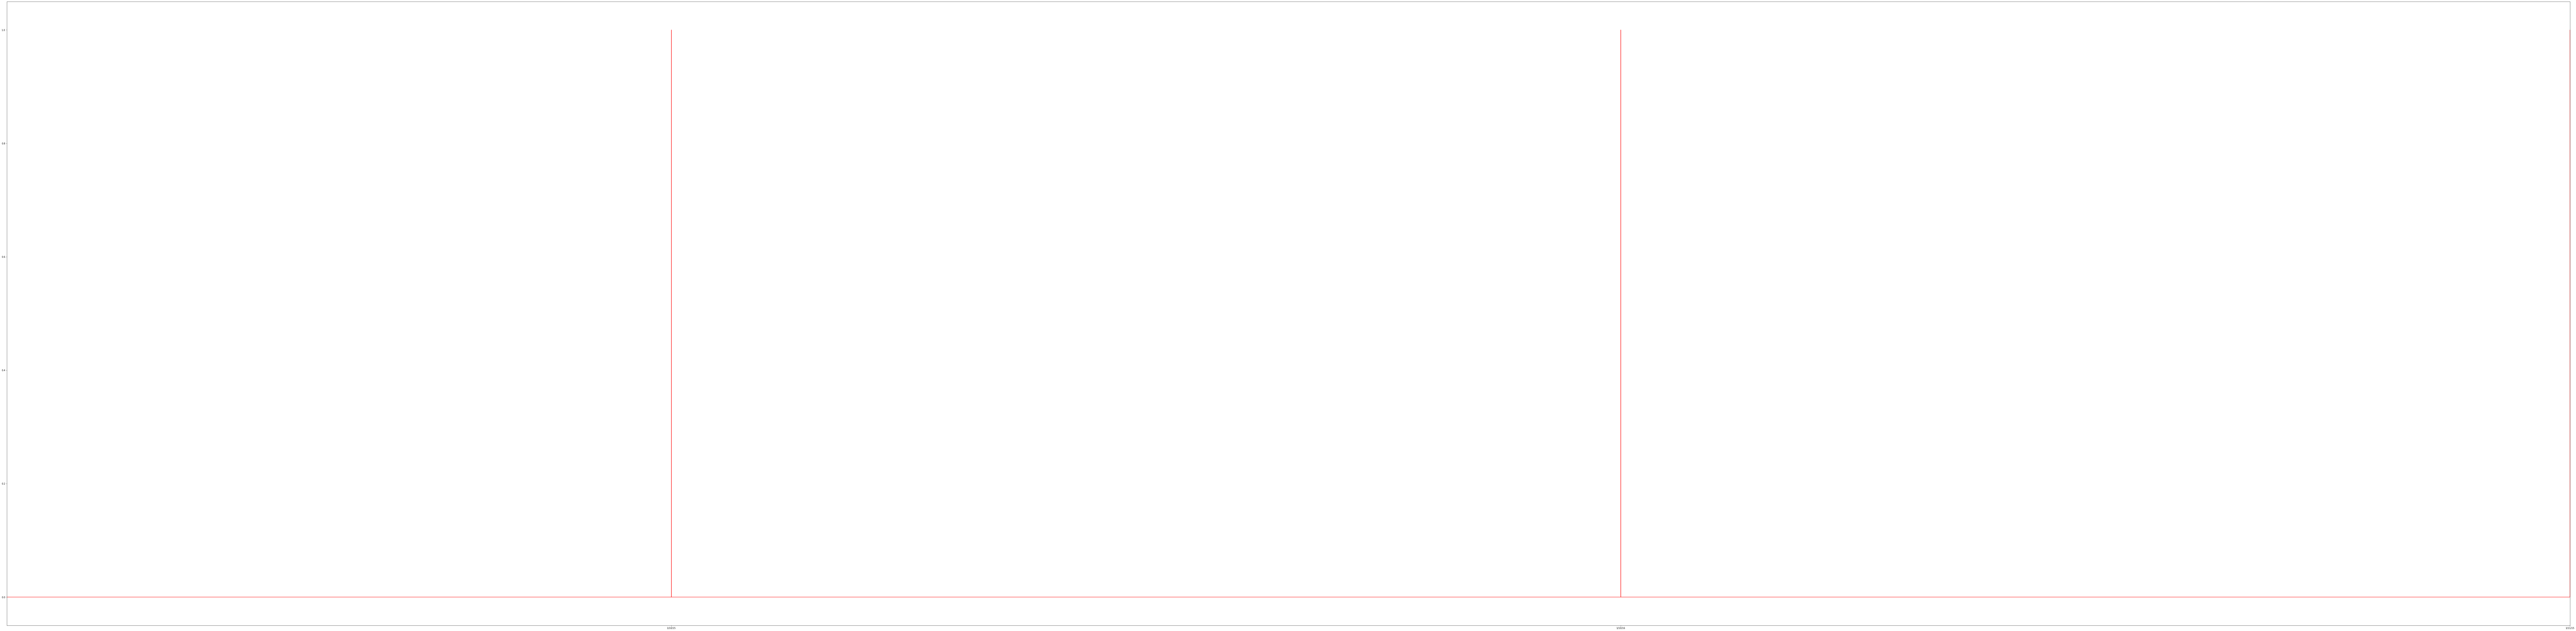

In [94]:
# Using graph_objects
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

#import plotly.plotly as py

import matplotlib.pyplot as plt
from matplotlib import pyplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import plotly.graph_objs as go


plt.figure(figsize=(200,50))

#plt.plot(Xdate, yvalue)
plt.plot(Xdate, sensor_sorted['anomaly'], color="r")
plt.xlim(1.3, 4.0)
plt.show()
#iplot(fig)

In [95]:
from matplotlib.figure import Figure
from matplotlib.backends.backend_gtkagg import FigureCanvasGTKAgg as FigureCanvas
from matplotlib.backends.backend_gtkagg import NavigationToolbar2GTKAgg as NavigationToolbar

win = gtk.Window()
win.connect("destroy", lambda x: gtk.main_quit())
win.set_default_size(400,300)
win.set_title("Embedding in GTK")

vbox = gtk.VBox()
win.add(vbox)

fig = Figure(figsize=(5,4), dpi=100)
ax = fig.add_subplot(111)
ax.plot([1,2,3])

canvas = FigureCanvas(fig)  # a gtk.DrawingArea
vbox.pack_start(canvas)
toolbar = NavigationToolbar(canvas, win)
vbox.pack_start(toolbar, False, False)

win.show_all()
gtk.main()

ModuleNotFoundError: No module named 'matplotlib.backends.backend_gtkagg'

In [ ]:
plt.figure(figsize=(60,10))

plt.plot(Xdate, yvalue)
plt.show()
#iplot(fig)

In [73]:
df=sensor_sorted

df['anomaly']=sensor_sorted['S5']

df['timestamp']=sensor_sorted['DATE']

def plot_anomaly(df,metric_name):
   # df.timestamp = pd.to_datetime(df['timestamp'].astype(str), format="%Y-%m-%d %H:%M:%S")
    dates = df.timestamp
    #identify the anomaly points and create a array of its values for plot
    bool_array = (abs(sensor_sorted['anomaly']) > 0)
    actuals = sensor_sorted['S5'][-len(bool_array):]
    anomaly_points = bool_array * actuals
    anomaly_points[anomaly_points == 0] = np.nan
    #A dictionary for conditional format table based on anomaly
    color_map = {0: "blue", 1: "red"}
#Table which includes Date,Actuals,Change occured from previous point
    table = go.Table(
    domain=dict(x=[0, 1],
                y=[0, 0.3]),
    columnwidth=[1, 2],
    # columnorder=[0, 1, 2,],
    header=dict(height=20,
                values=[['<b>Date</b>'], ['<b>Actual Values </b>'],
                        ],
                font=dict(color=['rgb(45, 45, 45)'] * 5, size=14),
                fill=dict(color='#d562be')),
    cells=dict(values=[sensor_sorted.round(3)[k].tolist() for k in ['DATE', 'S5']],
               line=dict(color='#506784'),
               align=['center'] * 5,
               font=dict(color=['rgb(40, 40, 40)'] * 5, size=12),
               # format = [None] + [",.4f"] + [',.4f'],
               # suffix=[None] * 4,
               suffix=[None] + [''] + [''] + ['%'] + [''],
               height=27,
               fill=dict(color=[sensor_sorted['anomaly'].map(color_map)],#map based on anomaly level from dictionary
               )
               ))
    #Plot the actuals points
    Actuals = go.Scatter(name='Actuals',
                     x=sensor_sorted['DATE'],
                     y=sensor_sorted['S5'],
                     xaxis='x1', yaxis='y1',
                     mode='line',
                     marker=dict(size=12,
                                 line=dict(width=1),
                                 color="blue"))
    #Highlight the anomaly points
    anomalies_map = go.Scatter(name="Anomaly",
                               showlegend=True,
                               x=sensor_sorted['DATE'],
                               y=anomaly_points,
                               mode='markers',
                               xaxis='x1',
                               yaxis='y1',
                               marker=dict(color="red",
                                           size=11,
                                           line=dict(
                                               color="red",
                                               width=2)))
    axis = dict(
        showline=True,
        zeroline=False,
        showgrid=True,
        mirror=True,
        ticklen=4,
        gridcolor='#ffffff',
        tickfont=dict(size=10))
    layout = dict(
        width=1000,
        height=865,
        autosize=False,
        title=metric_name,
        margin=dict(t=75),
        showlegend=True,
        xaxis1=dict(axis, **dict(domain=[0, 1], anchor='y1', showticklabels=True)),
        yaxis1=dict(axis, **dict(domain=[2 * 0.21 + 0.20, 1], anchor='x1', hoverformat='.2f')))
    fig = go.Figure(data=[table, anomalies_map, Actuals], layout=layout)
    iplot(fig)
    pyplot.show()
plot_anomaly(sensor_sorted,'anomalies')

TypeError: 'str' object is not callable

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import eia
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    Arguments:
        api: API that we're connected to
        series_ID: string. Name of the series that we want to pull from the EIA API
    Outputs:
        df: Pandas dataframe of time series
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    df = pd.DataFrame(series_search)
    return df
def scatterplot(x_data, y_data, x_label, y_label, title):
    """
    Arguments:
        x_data: Series. Desired x-axis for scatterplot.
        y_data: Series. Desired y-axis for scatterplot.
        x_label: String. Label for x-axis.
        y_label: String. Label for y-axis.
        title: String. Title of plot
    Outputs:
        Scatterplot in console.
    """
    fig, ax = plt.subplots()
    ax.scatter(x_data, y_data, s = 30, color = '#539caf', alpha = 0.75)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    fig.autofmt_xdate()
    
#####EXECUTE IN MAIN BLOCK
#Create EIA API using your specific API key
api_key = 'YOUR API KEY HERE'
api = eia.API(api_key)
    
#Pull the oil WTI price data
series_ID='PET.EER_EPMRU_PF4_RGC_DPG.D'
sensor_sorted=retrieve_time_series(api, series_ID)
sensor_sorted.reset_index(level=0, inplace=True)
#Rename the columns for easer analysis
sensor_sorted.rename(columns={'index':'Date',
            sensor_sorted.columns[1]:'Gasoline_Price'}, 
            inplace=True)
     
#Visualize anomalies using matplotlib function



scatterplot(sensor_sorted['DATE'],
                sensor_sorted['S5'], 
                'Date', 
                'Gasoline Price (Dollars Per Gallon)', 
                'US Gulf Coast Gasoline Price Time Series: 2014-Present')

KeyError: 'series'

In [29]:
# evaluate model performance with outliers removed using isolation forest
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_absolute_error
# load the dataset
#url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv'
#df = read_csv(url, header=None)
# retrieve the array
#data = df.values
# split into input and output elements
#X, y = data[:, :-1], data[:, -1]
X=Xs
y=ys
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# summarize the shape of the training dataset
print(X_train.shape, y_train.shape)
# identify outliers in the training dataset
iso = IsolationForest(contamination=0.1)
yhat = iso.fit_predict(X_train)
# select all rows that are not outliers
#mask = yhat != -1
#X_train, y_train = X_train[mask, :], y_train[mask]
# summarize the shape of the updated training dataset
print(X_train.shape, y_train.shape)
# fit the model
model = LinearRegression()
model.fit(X_train, y_train)
# evaluate the model
yhat = model.predict(X_test)
# evaluate predictions
mae = mean_absolute_error(y_test, yhat)
print('MAE: %.3f' % mae)

(6700, 5) (6700,)
(6700, 5) (6700,)
MAE: 0.005


In [22]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [30]:
yhat
iso

IsolationForest(contamination=0.1)

In [75]:
pip install EIA-python

Note: you may need to restart the kernel to use updated packages.


 #  isolation forest - neues beispiel

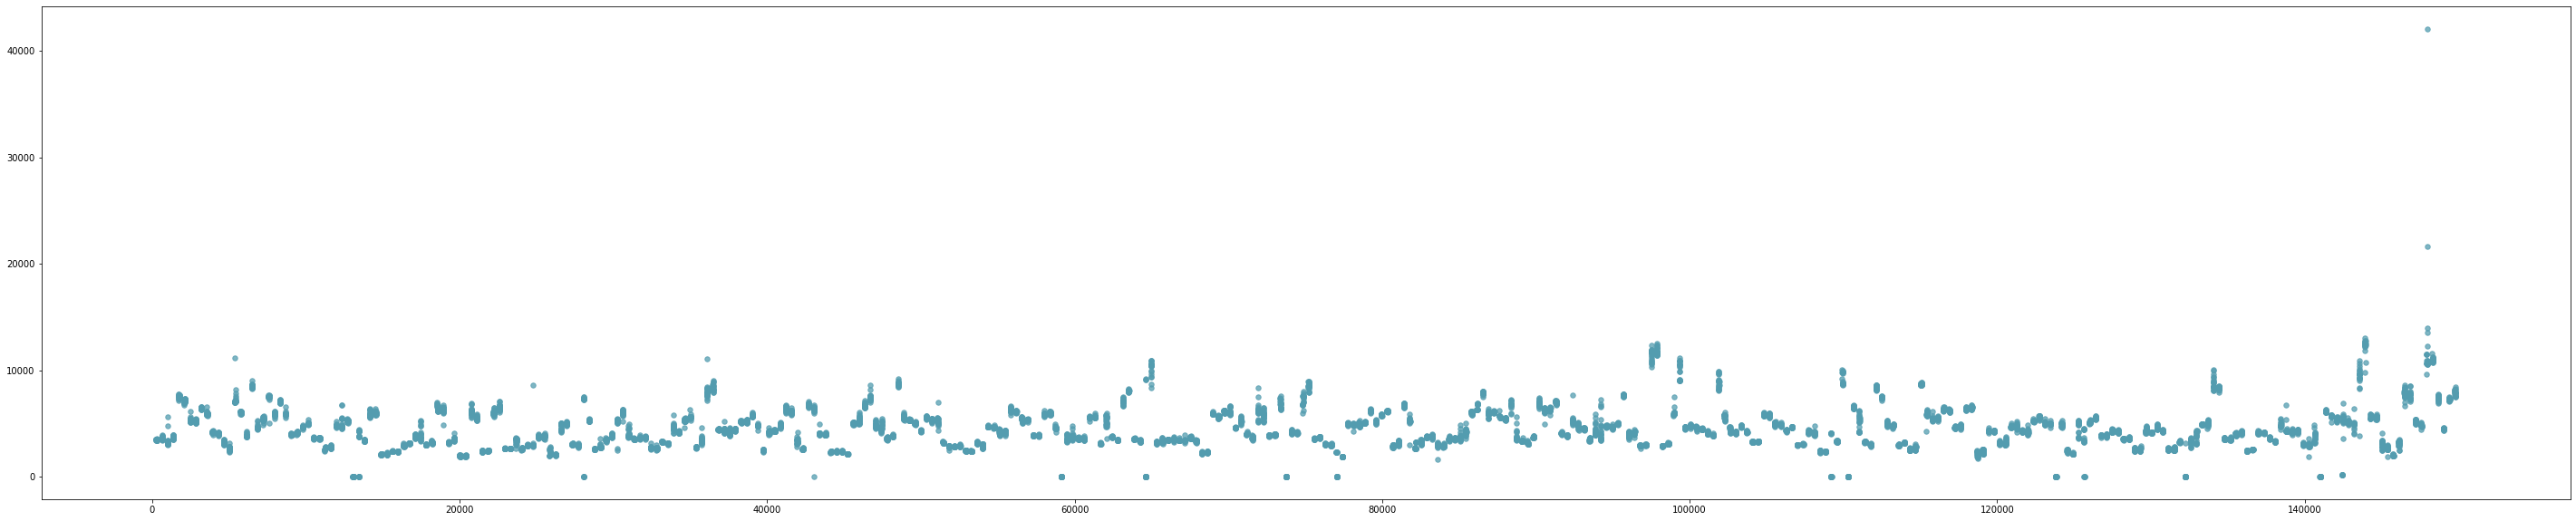

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import eia
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    Arguments:
        api: API that we're connected to
        series_ID: string. Name of the series that we want to pull from the EIA API
    Outputs:
        df: Pandas dataframe of time series
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    df = pd.DataFrame(series_search)
    return df
def scatterplot(x_data, y_data, x_label, y_label, title):
    """
    Arguments:
        x_data: Series. Desired x-axis for scatterplot.
        y_data: Series. Desired y-axis for scatterplot.
        x_label: String. Label for x-axis.
        y_label: String. Label for y-axis.
        title: String. Title of plot
    Outputs:
        Scatterplot in console.

    """
    #fig, ax = plt
    
    plt.figure(figsize=(50, 10))
    plt.scatter(x_data, y_data, s = 30, color = '#539caf', alpha = 0.75)
    #plt.set_title(title)
    #plt.set_xlabel(x_label)
    #plt.set_ylabel(y_label)
    #fig.autofmt_xdate()
    
#####EXECUTE IN MAIN BLOCK
#Create EIA API using your specific API key
#api_key = 'YOUR API KEY HERE'
#api = eia.API(api_key)
    
#Pull the oil WTI price data
#series_ID='PET.EER_EPMRU_PF4_RGC_DPG.D'
gasoline_price_df=sensor_sorted
#gasoline_price_df.reset_index(level=0, inplace=True)
#Rename the columns for easer analysis
gasoline_price_df.rename(columns={'index':'DATE',
            gasoline_price_df.columns[1]:'S5'}, 
            inplace=True)
     
#Visualize anomalies using matplotlib function
scatterplot(sensor_sorted.index.values[-9000:],
                yvalue[-9000:], 
                'Date', 
                'Gasoline Price (Dollars Per Gallon)', 
                'US Gulf Coast Gasoline Price Time Series: 2014-Present')
    

In [49]:

from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_absolute_error

def isolation_forest_anomaly_detection(df, 
                                       column_name, 
                                       outliers_fraction):
    """
    In this definition, time series anomalies are detected using an Isolation Forest algorithm.
    Arguments:
        df: Pandas dataframe
        column_name: string. Name of the column that we want to detect anomalies in
        outliers_fraction: float. Percentage of outliers allowed in the sequence.
    Outputs:
        df: Pandas dataframe with column for detected Isolation Forest anomalies (True/False)
    """
    #Scale the column that we want to flag for anomalies
    min_max_scaler = preprocessing.StandardScaler()
    np_scaled = min_max_scaler.fit_transform(df[[column_name]])
    scaled_time_series = pd.DataFrame(np_scaled)
    # train isolation forest 
    model =  IsolationForest(contamination = outliers_fraction, behaviour='new')
    model.fit(scaled_time_series)
    #Generate column for Isolation Forest-detected anomalies
    isolation_forest_anomaly_column = column_name+'_Isolation_Forest_Anomaly'
    df[isolation_forest_anomaly_column] = model.predict(scaled_time_series)
    df[isolation_forest_anomaly_column] = df[isolation_forest_anomaly_column].map( {1: False, -1: True} )
    return df
##EXECUTE IN MAIN BLOCK
#APPLY ISOLATION FOREST TO DETECT ANOMALIES
gasoline_price_df=isolation_forest_anomaly_detection(df=sensor_sorted_ohne_date, 
                                                         column_name='S5', 
                                                         outliers_fraction=.04)
#Re-plot time series with color coding for anomaly column
scatterplot_with_color_coding(sensor_sorted_ohne_date.index.values[:9000],
                                  yvalue[:9000], 
                                  gasoline_price_df['Gasoline_Price_Isolation_Forest_Anomaly'],
                                  'Date', 
                                  'Gasoline Price (Dollars Per Gallon)', 
                                  'Gasoline Prices, Color-Coded on Isolation Forest Anomalies') 

TypeError: __init__() got an unexpected keyword argument 'behaviour'

In [106]:
Xdate.shape

(149855,)

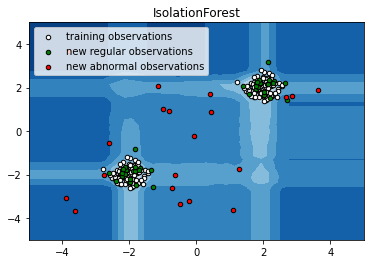

In [51]:
 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

rng = np.random.RandomState(42)

# Generate train data
X = 0.3 * rng.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
# Generate some regular novel observations
X = 0.3 * rng.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = rng.uniform(low=-4, high=4, size=(20, 2))

# fit the model
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

# plot the line, the samples, and the nearest vectors to the plane
xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("IsolationForest")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white',
                 s=20, edgecolor='k')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='green',
                 s=20, edgecolor='k')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red',
                s=20, edgecolor='k')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([b1, b2, c],
           ["training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left")
plt.show()

# isolation forest- regression beispiel

https://towardsdatascience.com/isolation-forest-with-statistical-rules-4dd27dad2da9#:~:text=With%20isolation%20forest%20we%20had,our%20data%20to%20be%20anomalous.&text=Isolation%20forest%20separates%20each%20point,representing%20a%20node%20in%20tree

In [54]:
import pandas as pd
import numpy as np
full_df=pd.read_csv('https://raw.githubusercontent.com/numenta/NAB/master/data/realAWSCloudwatch/ec2_cpu_utilization_5f5533.csv')
full_df.head()

,timestamp,value
0,2014-02-14 14:27:00,51.846
1,2014-02-14 14:32:00,44.508
2,2014-02-14 14:37:00,41.244
3,2014-02-14 14:42:00,48.568
4,2014-02-14 14:47:00,46.714


In [56]:
print(full_df['timestamp'].min())
print(full_df['timestamp'].max())
print(len(full_df['timestamp']))

2014-02-14 14:27:00
2014-02-28 14:22:00
4032


In [98]:
# Using graph_objects
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import matplotlib.pyplot as plt
from matplotlib import pyplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import plotly.graph_objs as go
fig = go.Figure(data=[go.Scatter(x=df['timestamp'], y=df['value'])])
iplot(fig)

In [ ]:
plot_data=go.Scatter(x=df['timestamp'], y=df['value'])
fig=go.Figure(data=[plot_data])
iplot(fig)

In [77]:
full_df['timestamp'].describe

<bound method NDFrame.describe of 0       2014-02-14 14:27:00
1       2014-02-14 14:32:00
2       2014-02-14 14:37:00
3       2014-02-14 14:42:00
4       2014-02-14 14:47:00
               ...         
4027    2014-02-28 14:02:00
4028    2014-02-28 14:07:00
4029    2014-02-28 14:12:00
4030    2014-02-28 14:17:00
4031    2014-02-28 14:22:00
Name: timestamp, Length: 4032, dtype: object>

In [102]:
from sklearn.ensemble import IsolationForest
#to_model_column='value'
clf=IsolationForest(n_estimators=10, max_samples='auto', contamination=float(.04))
                       # max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0,behaviour='new')
clf.fit(df[['value']])
df['scores']=clf.decision_function(df[['value']])
df['anomaly']=clf.predict(df[['value']])
df.head()
df.loc[df['anomaly'] == 1,'anomaly'] = 0
df.loc[df['anomaly'] == -1,'anomaly'] = 1
#df.value_counts()
df['anomaly'].value_counts()

0    3872
1     160
Name: anomaly, dtype: int64

In [118]:


def plot_anomaly(df,metric_name):
    df.timestamp = pd.to_datetime(df['timestamp'].astype(str), format="%Y-%m-%d %H:%M:%S")
    dates = df.timestamp
    #identify the anomaly points and create a array of its values for plot
    bool_array = (abs(df['anomaly']) > 0)
    actuals = df["value"][-len(bool_array):]
    anomaly_points = bool_array * actuals
    anomaly_points[anomaly_points == 0] = np.nan
    #A dictionary for conditional format table based on anomaly
    color_map = {0: "blue", 1: "red"}
#Table which includes Date,Actuals,Change occured from previous point
    table = go.Table(
    domain=dict(x=[0, 1],
                y=[0, 0.3]),
    columnwidth=[1, 2],
    # columnorder=[0, 1, 2,],
    header=dict(height=20,
                values=[['<b>Date</b>'], ['<b>Actual Values </b>'],
                        ],
                font=dict(color=['rgb(45, 45, 45)'] * 5, size=14),
                fill=dict(color='#d562be'
                
                )),
    cells=dict(values=[df.round(3)[k].tolist() for k in ['timestamp', 'value']],
               line=dict(color='#506784'),
               align=['center'] * 5,
               font=dict(color=['rgb(40, 40, 40)'] * 5, size=12),
               # format = [None] + [",.4f"] + [',.4f'],
               # suffix=[None] * 4,
               suffix=[None] + [''] + [''] + ['%'] + [''],
               height=27,
               fill=dict(color=[df['anomaly'].map(color_map)],#map based on anomaly level from dictionary
               )
               ))
    #Plot the actuals points
    Actuals = go.Scatter(name='Actuals',
                     x=dates,
                     y=df['value'],
                     xaxis='x1', yaxis='y1',
                     mode='lines',
                     marker=dict(size=12,
                                 line=dict(width=1),
                                 color="blue"))
    #Highlight the anomaly points
    anomalies_map = go.Scatter(name="Anomaly",
                               showlegend=True,
                               x=dates,
                               y=anomaly_points,
                               mode='markers',
                               xaxis='x1',
                               yaxis='y1',
                               marker=dict(color="red",
                                           size=11,
                                           line=dict(
                                               color="red",
                                               width=2)))
    axis = dict(
        showline=True,
        zeroline=False,
        showgrid=True,
        mirror=True,
        ticklen=4,
        gridcolor='#ffffff',
        tickfont=dict(size=10))
    layout = dict(
        width=1000,
        height=865,
        autosize=False,
        title=metric_name,
        margin=dict(t=75),
        showlegend=True,
        xaxis1=dict(axis, **dict(domain=[0, 1], anchor='y1', showticklabels=True)),
        yaxis1=dict(axis, **dict(domain=[2 * 0.21 + 0.20, 1], anchor='x1', hoverformat='.2f')))
    fig = go.Figure(data=[table, anomalies_map, Actuals], layout=layout)
    iplot(fig)
    pyplot.show()


In [120]:
plot_anomaly(df,'anomalies')